# Thornthwaite-Matter Procedure to Calculate the Groundwater Recharge

This notebook as an objective to calculate the groundwater recharge of the area of interest and produce a recharge map for the region of Caçapava-SP. This notebook only was possible due the tutorial of [Attard](https://guillaumeattard.com/groundwater-recharge-estimation-using-earth-engine/)

The following definition is according with Allen et al., 1998.

One area will have groundwater recharge at month when the Potential Evapotranspiration (PET) < Precipitation (P) and the water stored in the root zone (ST) > available water stored at the field capacity in the root zone (STFC or RAW). But there are other possibilities as when P > PET or STFC > ST. So the Thornthwaite-Matter procedure account for all possibilities as follow:

**Case 1** - $ PET > P $:

$ ST_m = STFC * exp(\frac{- APWL_m}{STFC}) $

and,

$ APWL_m = APWL_{m-1} + (PET_m - P_m) $

Where: 
* $ ST_m $ is the water stored in the root zone in the month m
* $ STFC $ is the available water stored at the field capacity in the root zone
* $ APWL_m $ is the accumulated potential water loss for the month m
* $ PET_m $ is the potential evapotranspiration for the month m
* $ P_m $ is the precipitation for the month m

---
**Case 2** - $ PET < P $:

$ ST_m = ST_{m-1} + (P_m - PET_m) $

and we apply it on:

**Case 2.1** - $ ST_m > STFC $:

$ R_m = ST_m + P_m - PET_m $

Where:
* $ R_m $ is the recharge for the month m

**Case 2.2** - $ ST_m <= STFC $:

$ APWL_m = STFC * ln(\frac{ST_m}{STFC}) $

---

We can obtain the STFC by:

$ STFC = p * TAW $

and,

$ TAW = 1000 * (\theta_{FC} - \theta_{WP} * Z_r) $

Where:
* $ TAW $ is the total available soil water in the root zone ($ mm $)
* $ \theta_{FC} $ is the water content at the field capacity ($ m^3 m^{-3} $)
* $ \theta_{WP} $ is the water content at the wilting point ($ m^3 m^{-3} $)
* $ Z_r $ is the rooting depth ($m$)
* $ p $ is the average fraction of $ TAW $ that can be depleted from the root zone before moisture stress

---
With the data obtained in the [Yuting et al, 2016](https://data.csiro.au/collection/csiro:19813v1) is possible to get the $ p $ and the $ Z_r $ values for the Caçapava region.

With the data from [Tomislav, 2018a](https://zenodo.org/record/2525662#.Yq-s3_3MKUk), [Tomislav, 2018b](https://zenodo.org/record/2525663#.Yq-tHv3MKUk), and [Tomislav and Wheeler, 2018](https://zenodo.org/record/2525553#.Yq-tRP3MKUk) is possible to calculate the $ \theta_{FC} $ and $ \theta_{WP} $ (Saxton and Rawls, 2006) as follow:

$ \theta_{WP} = \theta_{1500t} + (0.14 * \theta_{1500t} - 0.002) $

and,

$ \theta_{1500t} = -0.024 S + 0.487 C + 0.006 OM + 0.005 (S * OM) - 0.013 (C * OM) + 0.068 (S * C) + 0.031 $

and;

$ \theta_{FC} = \theta_{33t} + (1.283 * \theta_{33t}^{2} - 0.374 * \theta_{33t} - 0.15) $

and,

$ \theta_{33t} = -0.251 S + 0.195 C + 0.011 OM + 0.006 (S * OM) - 0.027 (C * OM) + 0.452 (S * C) + 0.299 $

Where:
* $ S $ is the mass percent sand of the soil
* $ C $ is the mass percent clay of the soil
* $ OM $ is the mass percent organic matter of the soil

The remmaing parameter $ PET $ and $ P $ was obtained in the [Funk er al., 2015](https://www.nature.com/articles/sdata201566) and [Running et al., 2017](https://lpdaac.usgs.gov/products/mod16a2v006/)


In [5]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import pprint
import branca.colormap as cm

Setting the interval to get data and the area od interest (Caçapava - SP)

In [7]:
i_date = "2012-01-01"
f_date = "2022-01-01"

#area of interest
lon = -45.685694
lat = -23.100421
poi = ee.Geometry.Point(lon, lat)

scale = 1000

## Soil texture to hydraulic properties
Getting the soil texture profiles

In [8]:
olm_depths = [0, 10, 30, 60, 100, 200]
olm_bands = ["b" + str(sd) for sd in olm_depths]
olm_bands

['b0', 'b10', 'b30', 'b60', 'b100', 'b200']

In [9]:
#sand image
snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
scale_factor = 0.01
sand = ee.Image(snippet).multiply(scale_factor)

In [10]:
#clay image
snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
scale_factor = 0.01
clay = ee.Image(snippet).multiply(scale_factor)

In [11]:
#organic carbon image
snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
scale_factor = 5 * 0.001 #to get kg/kg
orgc = ee.Image(snippet).multiply(scale_factor)

Vizualizing the sand content in the region of Caçapava

In [12]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)


# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

my_map = folium.Map(location=[lat, lon], zoom_start=8)

# Set visualization parameters.
vis_params = {
    "bands": ["b0"],
    "min": 0.01,
    "max": 1,
    "opacity": 1,
    "palette": ["white", "#464646"],
}

# Add the sand content data to the map object.
my_map.add_ee_layer(sand, vis_params, "Sand Content")

# Add a marker at the location of interest.
folium.Marker([lat, lon], popup="point of interest").add_to(my_map)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Getting soil properties profiles in the region of interest.
example below is to obtain the sand profile

In [13]:
sand_prop = sand.sample(poi, scale).select(olm_bands).getInfo()
sand_prop

{'type': 'FeatureCollection',
 'columns': {},
 'properties': {'band_order': ['b0', 'b10', 'b30', 'b60', 'b100', 'b200']},
 'features': [{'type': 'Feature',
   'geometry': None,
   'id': '0',
   'properties': {'b0': 0.44,
    'b10': 0.44,
    'b100': 0.41000000000000003,
    'b200': 0.43,
    'b30': 0.41000000000000003,
    'b60': 0.41000000000000003}}]}

In [14]:
profile_sand = sand_prop["features"][0]["properties"]
profile_sand = {key: round(val, 3) for key, val in profile_sand.items()}
profile_sand

{'b0': 0.44, 'b10': 0.44, 'b100': 0.41, 'b200': 0.43, 'b30': 0.41, 'b60': 0.41}

Doing the same to get clay and organic matter profiles

Note that the organic carbon need to be converted to organic matter to be used in equation of Saxton and Rawls [2006]. It can be did by using the equation:

$ OM = 1.724 OC $

where $ OM $ is organic matter and $ OC $ is the organic carbon

In [15]:
clay_prop = clay.sample(poi, scale).select(olm_bands).getInfo()
profile_clay = clay_prop["features"][0]["properties"]
profile_clay = {key: round(val, 3) for key, val in profile_clay.items()}

orgc_prop = orgc.sample(poi, scale).select(olm_bands).getInfo()
profile_orgc = orgc_prop["features"][0]["properties"]
profile_orgm = {key: round(val * 1.724, 3) for key, val in profile_orgc.items()}
orgm = orgc.multiply(1.724)

Vizualizing the soil properties profile of the area of interest

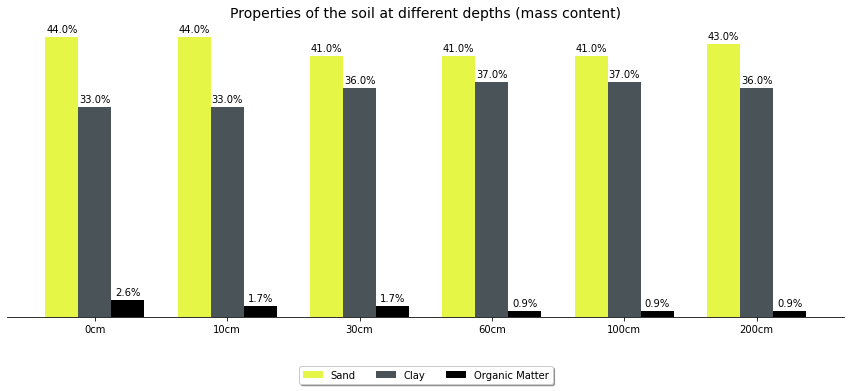

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

x = np.arange(len(olm_bands))

width = 0.25

#bar sand
rect1 = ax.bar(x - width, 
    [round(100 * profile_sand[b], 2) for b in olm_bands],
    width=width, 
    label="Sand", 
    color="#e6f647")
#bar clay
rect2 = ax.bar(x, 
    [round(100 * profile_clay[b], 2) for b in olm_bands],
    width=width, 
    label="Clay",
    color="#495358")
#bar organic matter
rect3 = ax.bar(x + width,
    [round(100 * profile_orgm[b], 2) for b in olm_bands], 
    width=width, 
    label="Organic Matter", 
    color="000000", 
    #alpha=0.75, 
    )

def autolabel_soil_prop(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{}".format(height) + "%", 
            xy=(rect.get_x() + rect.get_width() / 2, height), 
            xytext=(0, 3), 
            textcoords="offset points", 
            ha="center", 
            va="bottom", 
            fontsize=10)
autolabel_soil_prop(rect1)
autolabel_soil_prop(rect2)
autolabel_soil_prop(rect3)

ax.set_title("Properties of the soil at different depths (mass content)", fontsize=14)

ax.set_xticks(x)
x_labels = [str(d) + "cm" for d in olm_depths]
ax.set_xticklabels(x_labels, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

ax.legend(loc="upper center", 
    bbox_to_anchor=(0.5, -0.15), 
    fancybox=True,
    shadow=True, 
    ncol = 3)

plt.show()

## Calculating the wilting point and field capacity

Applying the mathematical expression:

$ \theta_{WP} = \theta_{1500t} + (0.14 * \theta_{1500t} - 0.002) $

and,

$ \theta_{1500t} = -0.024 S + 0.487 C + 0.006 OM + 0.005 (S * OM) - 0.013 (C * OM) + 0.068 (S * C) + 0.031 $

and;

$ \theta_{FC} = \theta_{33t} + (1.283 * \theta_{33t}^{2} - 0.374 * \theta_{33t} - 0.15) $

and,

$ \theta_{33t} = -0.251 S + 0.195 C + 0.011 OM + 0.006 (S * OM) - 0.027 (C * OM) + 0.452 (S * C) + 0.299 $

In [17]:
wilting_point = ee.Image(0)
field_capacity = ee.Image(0)

for key in olm_bands:
    si = sand.select(key)
    ci = clay.select(key)
    oi = orgm.select(key)

    #calculate wilting point at band i
    theta_1500ti = (
        ee.Image(0).expression(
            "-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM) - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031", 
            {"S": si, "C": ci, "OM": oi}
        ).rename("T1500ti")
    )

    wpi = theta_1500ti.expression(
        "T1500ti + (0.14 * T1500ti - 0.002)", 
        {"T1500ti": theta_1500ti}
    ).rename("wpi")

    wilting_point = wilting_point.addBands(wpi.rename(key).float())

    #calculate field capacity at band i
    theta_33ti = (
        ee.Image(0).expression(
            "-0.251 * S + 0.195 * C + 0.011 * OM + 0.006 * (S * OM) - 0.027 * (C * OM) + 0.452 * (S * C) + 0.299", 
            {"S": si, "C": ci, "OM": oi}
        ).rename("T33ti")
    )

    fci = theta_33ti.expression(
        "T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015)", 
        {"T33ti": theta_33ti.select("T33ti")}
    )

    field_capacity = field_capacity.addBands(fci.rename(key).float())

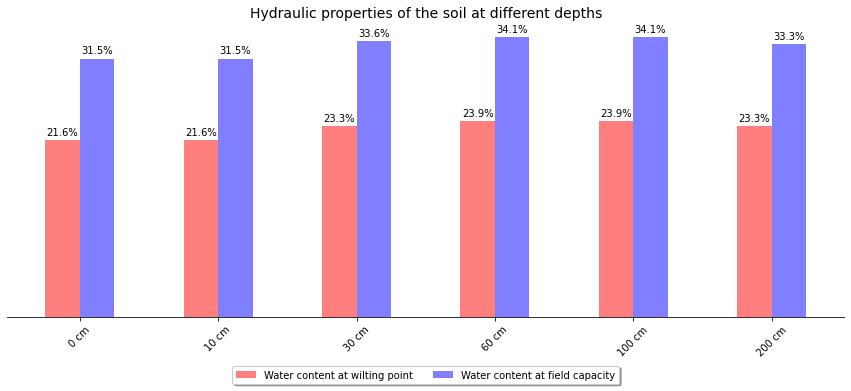

In [41]:
def local_profile(dataset, poi, buffer):
    # Get properties at the location of interest and transfer to client-side.
    prop = dataset.sample(poi, buffer).select(olm_bands).getInfo()

    # Selection of the features/properties of interest.
    profile = prop["features"][0]["properties"]

    # Re-shaping of the dict.
    profile = {key: round(val, 3) for key, val in profile.items()}

    return profile

profile_wp = local_profile(wilting_point, poi, scale)
profile_fc = local_profile(field_capacity, poi, scale)


fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

# Definition of the label locations.
x = np.arange(len(olm_bands))

# Width of the bar of the barplot.
width = 0.25

# Barplot associated with the water content at the wilting point.
rect1 = ax.bar(
    x - width / 2,
    [round(profile_wp[b] * 100, 2) for b in olm_bands],
    width,
    label="Water content at wilting point",
    color="red",
    alpha=0.5,
)

# Barplot associated with the water content at the field capacity.
rect2 = ax.bar(
    x + width / 2,
    [round(profile_fc[b] * 100, 2) for b in olm_bands],
    width,
    label="Water content at field capacity",
    color="blue",
    alpha=0.5,
)

# Add Labels on top of bars.
autolabel_soil_prop(rect1)
autolabel_soil_prop(rect2)

# Title of the plot.
ax.set_title("Hydraulic properties of the soil at different depths", fontsize=14)

# Properties of x/y labels and ticks.
ax.set_xticks(x)
x_labels = [str(d) + " cm" for d in olm_depths]
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Shrink current axis's height by 10% on the bottom.
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Put a legend below current axis.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2
)

plt.show()

## Meteorological Data

This data is obtained from:

* [CHIRPS Daily: Climate Hazards Group InfraRed Precipitation With Station Data (Version 2.0 Final)](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)
* [MOD16A2.006: Terra Net Evapotranspiration 8-Day Global 500m](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2)

In [19]:
#getting precipitation data
pr = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .select("precipitation").filterDate(i_date, f_date)
)

#getting potential evaporation data and its quality indicator
pet = (
    ee.ImageCollection("MODIS/006/MOD16A2")
    .select(["PET", "ET_QC"]).filterDate(i_date, f_date)
)

precipitation

In [20]:
local_pr = pr.getRegion(poi, scale).getInfo()
pprint.pprint(local_pr[:5])

[['id', 'longitude', 'latitude', 'time', 'precipitation'],
 ['20120101',
  -45.68382377389827,
  -23.100177531133497,
  1325376000000,
  33.581546783447266],
 ['20120102', -45.68382377389827, -23.100177531133497, 1325462400000, 0],
 ['20120103', -45.68382377389827, -23.100177531133497, 1325548800000, 0],
 ['20120104', -45.68382377389827, -23.100177531133497, 1325635200000, 0]]


In [21]:
#df precipitation
pr_df = pd.DataFrame(local_pr)
headers = pr_df.iloc[0]
pr_df = pd.DataFrame(pr_df.values[1:], columns=headers)

#pr data to numeric
pr_df["precipitation"] = pd.to_numeric(pr_df["precipitation"], errors="coerce")

#time field to datetime
pr_df["datetime"] = pd.to_datetime(pr_df["time"], unit="ms")

#cleaning
pr_df = pr_df[["time", "datetime", "precipitation"]]
pr_df = pr_df.set_index("datetime")

#vizualizing
pr_df.head()

,time,precipitation
datetime,,
2012-01-01,1325376000000,33.581547
2012-01-02,1325462400000,0.000000
2012-01-03,1325548800000,0.000000
2012-01-04,1325635200000,0.000000
2012-01-05,1325721600000,5.596924


doing the same for potential evaporation. Note the data is not daily as precipitation. It is 8 day average as described in the metadata.

In [22]:
#potential evaporation data
local_pet = pet.getRegion(poi, scale).getInfo()
pet_df = pd.DataFrame(local_pet)
headers = pet_df.iloc[0]
pet_df = pd.DataFrame(pet_df.values[1:], columns=headers)

#pet data to numeric
for band in ["PET", "ET_QC"]:
    pet_df[band] = pd.to_numeric(pet_df[band], errors="coerce")

#time to datetime
pet_df["datetime"] = pd.to_datetime(pet_df["time"], unit="ms")

#cleaning
pet_df = pet_df[["time", "datetime", "PET", "ET_QC"]]
pet_df = pet_df.set_index("datetime")

#vizualizing
pet_df.head()

,time,PET,ET_QC
datetime,,,
2012-01-01,1325376000000,504.0,157
2012-01-09,1326067200000,NaN,157
2012-01-17,1326758400000,NaN,157
2012-01-25,1327449600000,461.0,157
2012-02-02,1328140800000,649.0,157


Because the two datasets do not have the same timeline is necessary to resampling the time resolution to get a homogeneous time index and missing values. It will be achieved by resampling both datasets by month.

In [23]:
#this function is a code of Guillaume Attard. 
#Source: https://gist.github.com/guiattard/dc11243474d20c973d31cecb23524831#file-pfg6-meteo-6-py

def sum_resampler(coll, freq, unit, scale_factor, band_name):
    """
    This function aims to resample the time scale of an ee.ImageCollection.
    The function returns an ee.ImageCollection with the averaged sum of the
    band on the selected frequency.
    coll: (ee.ImageCollection) only one band can be handled
    freq: (int) corresponds to the resampling frequence
    unit: (str) corresponds to the resampling time unit.
                must be 'day', 'month' or 'year'
    scale_factor (float): scaling factor used to get our value in the good unit
    band_name (str) name of the output band
    """

    # Define initial and final dates of the collection.
    firstdate = ee.Date(
        coll.sort("system:time_start", True).first().get("system:time_start")
    )

    lastdate = ee.Date(
        coll.sort("system:time_start", False).first().get("system:time_start")
    )

    # Calculate the time difference between both dates.
    # https://developers.google.com/earth-engine/apidocs/ee-date-difference
    diff_dates = lastdate.difference(firstdate, unit)

    # Define a new time index (for output).
    new_index = ee.List.sequence(0, ee.Number(diff_dates), freq)

    # Define the function that will be applied to our new time index.
    def apply_resampling(date_index):
        # Define the starting date to take into account.
        startdate = firstdate.advance(ee.Number(date_index), unit)

        # Define the ending date to take into account according
        # to the desired frequency.
        enddate = firstdate.advance(ee.Number(date_index).add(freq), unit)

        # Calculate the number of days between starting and ending days.
        diff_days = enddate.difference(startdate, "day")

        # Calculate the composite image.
        image = (
            coll.filterDate(startdate, enddate)
            .mean()
            .multiply(diff_days)
            .multiply(scale_factor)
            .rename(band_name)
        )

        # Return the final image with the appropriate time index.
        return image.set("system:time_start", startdate.millis())

    # Map the function to the new time index.
    res = new_index.map(apply_resampling)

    # Transform the result into an ee.ImageCollection.
    res = ee.ImageCollection(res)

    return res

For evapotranspiration dataset gives us an 8-day sum and a scale factor of 10 is applied. We need to rescale by dividing by 8 and 10:

In [24]:
#resampling precipitation
pr_m = sum_resampler(pr, 1, "month", 1, "pr")

#resampling PET
pet_m = sum_resampler(pet.select("PET"), 1, "month", 0.0125, "pet")

Combining precipitation and PET datasets and vizualizing for the area of interest.

In [25]:
meteo = pr_m.combine(pet_m)
meteo_arr = meteo.getRegion(poi, scale).getInfo()

#meteo dataframe
meteo_df = pd.DataFrame(meteo_arr)
headers = meteo_df.iloc[0]
meteo_df = pd.DataFrame(meteo_df.values[1:], columns=headers)

#meteo data to numeric
for band in ["pr", "pet"]:
    meteo_df[band] = pd.to_numeric(meteo_df[band], errors="coerce")

#time field to datetime
meteo_df["datetime"] = pd.to_datetime(meteo_df["time"], unit="ms")

#cleaning
meteo_df = meteo_df[["time", "datetime", "pr", "pet"]]
meteo_df = meteo_df.set_index("datetime")
meteo_df = meteo_df.sort_index()

#vizualizing
meteo_df.head()

,time,pr,pet
datetime,,,
2012-01-01,1325376000000,276.223151,186.968750
2012-02-01,1328054400000,131.258315,197.804167
2012-03-01,1330560000000,113.144179,170.112500
2012-04-01,1333238400000,104.058466,126.375000
2012-05-01,1335830400000,61.901220,101.525000


Note that the above table has the monthly $ P $ and $ PET $ data for the area of interest.

Vizualizing these parameters for the area of interest during the interval of interest:

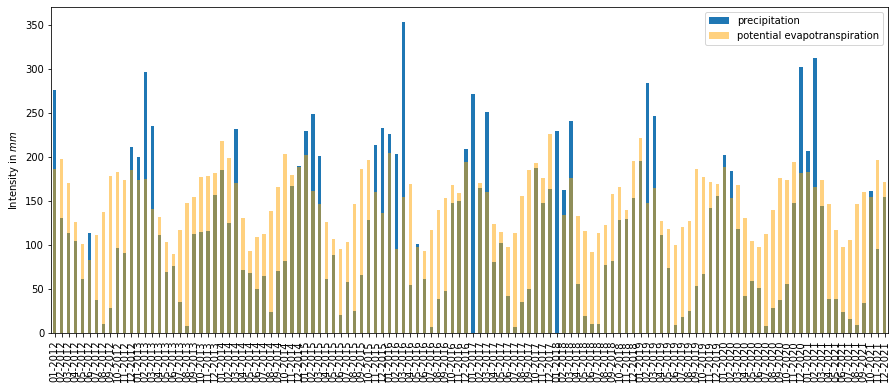

In [26]:
#data vizualization
fig, ax = plt.subplots(figsize=(15, 6))
meteo_df["pr"].plot(kind="bar", ax=ax, label="precipitation")
meteo_df["pet"].plot(kind="bar", ax=ax, label="potential evapotranspiration",
    color="orange",
    alpha=0.5, 
    )

ax.legend()
ax.set_ylabel("Intensity in $ mm $")
ax.set_xlabel(None)

x_labels = meteo_df.index.strftime("%m-%Y")
ax.set_xticklabels(x_labels, rotation=90, fontsize=10)

plt.show()

## Thornthwaite-Mather Procedure

With the meteorological data compilated we can do the final part of the TM procedure and estimate the groundwater recharge for each month during the interval os interest for our area of interest using: 

**Case 1** - $ PET > P $:

$ ST_m = STFC * exp(\frac{- APWL_m}{STFC}) $

and,

$ APWL_m = APWL_{m-1} + (PET_m - P_m) $

---

**Case 2** - $ PET < P $:

$ ST_m = ST_{m-1} + (P_m - PET_m) $

and we apply it on:

**Case 2.1** - $ ST_m > STFC $:

$ R_m = ST_m + P_m - PET_m $

**Case 2.2** - $ ST_m <= STFC $:

$ APWL_m = STFC * ln(\frac{ST_m}{STFC}) $

---

We can obtain the STFC by:

$ STFC = p * TAW $

and,

$ TAW = 1000 * (\theta_{FC} - \theta_{WP} * Z_r) $

In [27]:
zr = ee.Image(1.65)
p = ee.Image(0.5)

Averaging values of the soil properties

In [28]:
fcm = field_capacity.expression(
    "(b0 + b10 + b30 + b60 + b100 + b200) / 6", 
    {
        "b0": field_capacity.select("b0"), 
        "b10": field_capacity.select("b10"), 
        "b30": field_capacity.select("b30"), 
        "b60": field_capacity.select("b60"), 
        "b100": field_capacity.select("b100"), 
        "b200": field_capacity.select("b200"), 
    }
).rename("fc_mean")

wpm = wilting_point.expression(
    "(b0 + b10 + b30 + b60 + b100 + b200) / 6", 
    {
        "b0": wilting_point.select("b0"), 
        "b10": wilting_point.select("b10"), 
        "b30": wilting_point.select("b30"), 
        "b60": wilting_point.select("b60"), 
        "b100": wilting_point.select("b100"), 
        "b200": wilting_point.select("b200")
    }
).rename("wp_mean")

taw = (
    (fcm.select("fc_mean").subtract(wpm.select("wp_mean")))
    .multiply(1000).multiply(zr)
)

stfc = taw.multiply(p)

In [30]:
time0 = meteo.first().get("system:time_start")

initial_rech = ee.Image(0).set("system:time_start", time0).select([0], ["rech"]).float()

initial_apwl = ee.Image(0).set("system:time_start", time0).select([0], ["apwl"]).float()

initial_st = stfc.set("system:time_start", time0).select([0], ["st"]).float()

initial_pr = ee.Image(0).set("system:time_start", time0).select([0], ["pr"]).float()

initial_pet = ee.Image(0).set("system:time_start", time0).select([0], ["pet"]).float()

Combining all bands

In [31]:
initial_image = initial_rech.addBands(
    ee.Image([
        initial_apwl, 
        initial_st, 
        initial_pr, 
        initial_pet,
    ])
)

In [32]:
image_list = ee.List([initial_image])

Setting the expressions to calculate the groundwater recharge

In [33]:
#function of https://gist.github.com/guiattard/dc11243474d20c973d31cecb23524831#file-pfg6-tm-7-py
def recharge_calculator(image, image_list):
    """
    Contains operations made at each iteration.
    """
    # Determine the date of the current ee.Image of the collection.
    localdate = image.date().millis()

    # Import previous image stored in the list.
    prev_im = ee.Image(ee.List(image_list).get(-1))

    # Import previous APWL and ST.
    prev_apwl = prev_im.select("apwl")
    prev_st = prev_im.select("st")

    # Import current precipitation and evapotranspiration.
    pr_im = image.select("pr")
    pet_im = image.select("pet")

    # Initialize the new bands associated with recharge, apwl and st.
    # DO NOT FORGET TO CAST THE TYPE WITH .float().
    new_rech = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["rech"])
        .float()
    )

    new_apwl = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["apwl"])
        .float()
    )

    new_st = (
        prev_st.set("system:time_start", localdate).select([0], ["st"]).float()
    )

    # Calculate bands depending on the situation using binary layers with
    # logical operations.

    # CASE 1.
    # Define zone1: the area where PET > P.
    zone1 = pet_im.gt(pr_im)

    # Calculation of APWL in zone 1.
    zone1_apwl = prev_apwl.add(pet_im.subtract(pr_im)).rename("apwl")
    # Implementation of zone 1 values for APWL.
    new_apwl = new_apwl.where(zone1, zone1_apwl)

    # Calculate ST in zone 1.
    zone1_st = prev_st.multiply(
        ee.Image.exp(zone1_apwl.divide(stfc).multiply(-1))
    ).rename("st")
    # Implement ST in zone 1.
    new_st = new_st.where(zone1, zone1_st)

    # CASE 2.
    # Define zone2: the area where PET <= P.
    zone2 = pet_im.lte(pr_im)

    # Calculate ST in zone 2.
    zone2_st = prev_st.add(pr_im).subtract(pet_im).rename("st")
    # Implement ST in zone 2.
    new_st = new_st.where(zone2, zone2_st)

    # CASE 2.1.
    # Define zone21: the area where PET <= P and ST >= STfc.
    zone21 = zone2.And(zone2_st.gte(stfc))

    # Calculate recharge in zone 21.
    zone21_re = zone2_st.subtract(stfc).rename("rech")
    # Implement recharge in zone 21.
    new_rech = new_rech.where(zone21, zone21_re)
    # Implement ST in zone 21.
    new_st = new_st.where(zone21, stfc)

    # CASE 2.2.
    # Define zone 22: the area where PET <= P and ST < STfc.
    zone22 = zone2.And(zone2_st.lt(stfc))

    # Calculate APWL in zone 22.
    zone22_apwl = (
        stfc.multiply(-1).multiply(ee.Image.log(zone2_st.divide(stfc))).rename("apwl")
    )
    # Implement APWL in zone 22.
    new_apwl = new_apwl.where(zone22, zone22_apwl)

    # Create a mask around area where recharge can effectively be calculated.
    # Where we have have PET, P, FCm, WPm (except urban areas, etc.).
    mask = pet_im.gte(0).And(pr_im.gte(0)).And(fcm.gte(0)).And(wpm.gte(0))

    # Apply the mask.
    new_rech = new_rech.updateMask(mask)

    # Add all Bands to our ee.Image.
    new_image = new_rech.addBands(ee.Image([new_apwl, new_st, pr_im, pet_im]))

    # Add the new ee.Image to the ee.List.
    return ee.List(image_list).add(new_image)

Applying the expression

In [34]:
rech_list = meteo.iterate(recharge_calculator, image_list)

rech_list = ee.List(rech_list).remove(initial_image)

rech_coll = ee.ImageCollection(rech_list)

Vizualizing a table with the recharge of each month

In [35]:
rdf_arr = rech_coll.getRegion(poi, scale).getInfo()
rdf = pd.DataFrame(rdf_arr)
headers = rdf.iloc[0]
rdf = pd.DataFrame(rdf.values[1:], columns=headers)

#meteo data to numeric
for band in ["pr", "pet", "apwl", "st", "rech"]:
    rdf[band] = pd.to_numeric(rdf[band], errors="coerce")

#time field to datetime
rdf["datetime"] = pd.to_datetime(rdf["time"], unit="ms")

#cleaning
rdf = rdf[["time", "datetime", "pr", "pet", "apwl", "st", "rech"]]
rdf = rdf.set_index("datetime")
rdf = rdf.sort_index()

#vizualizing
rdf.head()

,time,pr,pet,apwl,st,rech
datetime,,,,,,
2012-01-01,1325376000000,276.223151,186.968750,0.000000,83.047841,89.254404
2012-02-01,1328054400000,131.258315,197.804167,66.545852,37.267493,0.000000
2012-03-01,1330560000000,113.144179,170.112500,346.168859,0.001159,0.000000
2012-04-01,1333238400000,104.058466,126.375000,190.247614,0.081574,0.000000
2012-05-01,1335830400000,61.901220,101.525000,104.974895,10.681127,0.000000


Vizualizing the recharge for each month

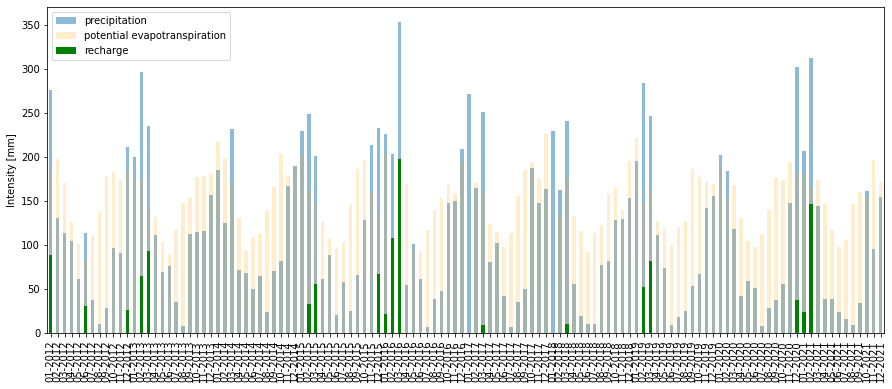

In [36]:
#data vizualization
fig, ax = plt.subplots(figsize=(15, 6))

rdf["pr"].plot(kind="bar", ax=ax, label="precipitation", alpha=0.5)

# Barplot associated with potential evapotranspiration.
rdf["pet"].plot(
    kind="bar", ax=ax, label="potential evapotranspiration", color="orange", alpha=0.2
)

# Barplot associated with groundwater recharge
rdf["rech"].plot(kind="bar", ax=ax, label="recharge", color="green", alpha=1)

# Add a legend.
ax.legend()

# Define x/y-labels properties.
ax.set_ylabel("Intensity [mm]")
ax.set_xlabel(None)

# Define the date format and shape of x-labels.
x_labels = rdf.index.strftime("%m-%Y")
ax.set_xticklabels(x_labels, rotation=90, fontsize=10)

plt.show()

Calculate the average of recharge per year for the area of interest

In [37]:
rdfy = rdf.resample("Y").sum()

# Calculate the mean value.
mean_recharge = rdfy["rech"].mean()

# Print the result.
print(
    "The mean annual recharge at our point of interest is", int(mean_recharge), "mm/an"
)

The mean annual recharge at our point of interest is 114 mm/an


Creating a map of the groundwater recharge. This can be vizualized [here](https://github.com/philliperalin/cacapava-wellfield-project/blob/main/results/recharge.png)

In [38]:
# Calculate the averaged annual recharge.
annual_rech = rech_coll.select("rech").mean().multiply(12)

# Calculate the average annual precipitation.
annual_pr = rech_coll.select("pr").mean().multiply(12)

# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection("FAO/GAUL/2015/level0").select("ADM0_NAME")

# Filter the feature collection to subset France.
brazil = countries.filter(ee.Filter.eq("ADM0_NAME", "Brazil"))

# Clip the composite ee.Images around the region of interest.
rech_brazil = annual_rech.clip(brazil)
pr_brazil = annual_pr.clip(brazil)

In [39]:
# Create a folium map.
my_map = folium.Map(location=[lat, lon], zoom_start=10, zoom_control=False)

# Set visualization parameters for recharge.
rech_vis_params = {
    "bands": "rech",
    "min": 0,
    "max": 500,
    "opacity": 1,
    "palette": ["red", "orange", "yellow", "green", "blue", "purple"],
}

# Set visualization parameters for precipitation.
pr_vis_params = {
    "bands": "pr",
    "min": 500,
    "max": 1500,
    "opacity": 1,
    "palette": ["white", "blue"],
}

# Define a recharge colormap.
rech_colormap = cm.LinearColormap(
    colors=rech_vis_params["palette"],
    vmin=rech_vis_params["min"],
    vmax=rech_vis_params["max"],
)

# Define a precipitation colormap.
pr_colormap = cm.LinearColormap(
    colors=pr_vis_params["palette"],
    vmin=pr_vis_params["min"],
    vmax=pr_vis_params["max"],
)

# Caption of the recharge colormap.
rech_colormap.caption = "Average annual recharge rate (mm/year)"

# Caption of the precipitation colormap.
pr_colormap.caption = "Average annual precipitation rate (mm/year)"

# Add the precipitation composite to the map object.
my_map.add_ee_layer(pr_brazil, pr_vis_params, "Precipitation")

# Add the recharge composite to the map object.
my_map.add_ee_layer(rech_brazil, rech_vis_params, "Recharge")

# Add a marker at both locations of interest.
folium.Marker([lat, lon], popup="Area of Interest").add_to(my_map)
#folium.Marker([lat2, lon2], popup="Area of Montpellier").add_to(my_map)

# Add the colormaps to the map.
my_map.add_child(rech_colormap)
my_map.add_child(pr_colormap)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

## References

Allen RG, Pereira LS, Raes D, Smith M (1998). Crop evapotranspiration: guidelines for computing crop water requirements. Irrigation and Drainage Paper 56, FAO, Rome.

Saxton, K. E., & Rawls, W. J. (2006). Soil water characteristic estimates by texture and organic matter for hydrologic solutions. Soil science society of America Journal, 70(5), 1569-1578.

Thornthwaite, C. W., & Mather, J. R. (1957). Instructions and tables for computing potential evapotranspiration and the water balance. Publ. Climatol., 10(3).

## Data
Funk, Chris, Pete Peterson, Martin Landsfeld, Diego Pedreros, James Verdin, Shraddhanand Shukla, Gregory Husak, James Rowland, Laura Harrison, Andrew Hoell & Joel Michaelsen. "The climate hazards infrared precipitation with stations—a new environmental record for monitoring extremes". Scientific Data 2, 150066. [doi:10.1038/sdata.2015.66](https://www.nature.com/articles/sdata201566) 2015.

Running, S., Mu, Q., Zhao, M. (2017). MOD16A2 MODIS/Terra Net Evapotranspiration 8-Day L4 Global 500m SIN Grid V006 [Data set]. NASA EOSDIS Land Processes DAAC. Accessed 2022-06-19 from [doi.org/10.5067/MODIS/MOD16A2.006](https://lpdaac.usgs.gov/products/mod16a2v006/)

Tomislav Hengl. (2018). Sand content in % (kg / kg) at 6 standard depths (0, 10, 30, 60, 100 and 200 cm) at 250 m resolution (Version v02) [Data set]. [doi.org/10.5281/zenodo.1476851](https://zenodo.org/record/2525662#.Yq-s3_3MKUk)

Tomislav Hengl. (2018). Clay content in % (kg / kg) at 6 standard depths (0, 10, 30, 60, 100 and 200 cm) at 250 m resolution (Version v02) [Data set]. [doi.org/10.5281/zenodo.1476854](https://zenodo.org/record/2525663#.Yq-tHv3MKUk)

Tomislav Hengl, & Ichsani Wheeler. (2018). Soil organic carbon content in x 5 g / kg at 6 standard depths (0, 10, 30, 60, 100 and 200 cm) at 250 m resolution (Version v02) [Data set]. Zenodo. [doi.org/10.5281/zenodo.1475457](https://zenodo.org/record/2525553#.Yq-tRP3MKUk)